In [120]:
import numpy as np
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [121]:
import nnfs
nnfs.init()
dataset=spiral_data(100, 3)

In [122]:
X, y = dataset

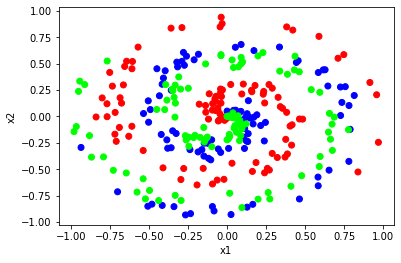

In [123]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:,0], X[:, 1], c=y, cmap='brg')
plt.show()

In [124]:
class Relu:
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0 

In [125]:
class Softmax:
    def forward(self, y):
        exp_val = np.exp(y - np.max(y, axis=1, keepdims=True))
        self.outputs = exp_val / np.sum(exp_val, axis=1, keepdims=True)
        return self.outputs 

In [126]:
class Softmax_and_LossCrossEntropy:
    def __init__(self):
        self.lossfunc=Softmax()

    def compute_loss(self, y_true):
        clipped= np.clip(self.output, 1e-7, 1 - 1e-7)
        self.loss = -np.log(clipped[np.arange(len(y_true)), y_true])
        return self.loss

    def forward(self, inputs, y_true):
        self.output = self.lossfunc.forward(inputs)
        self.compute_loss(y_true)

    def backward(self, y_true):
        self.dinputs=self.output.copy()
        self.dinputs[np.arange(len(y_true)), y_true]-=1
        self.dinputs/=len(y_true)

In [127]:
class MomemtumOptimizer:
    def __init__(self, lr=1.0, decay=0.005, beta=0.9):
        self.lr = lr
        self.init_lr = lr
        self.decay = decay
        self.iter = 0
        self.beta = beta

    def pre_update(self):
        self.lr = self.init_lr / (1 + self.decay * self.iter)

    def update_params(self, layer):
        if not hasattr(layer, "weight_momentum"):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)

        layer.weight_momentum = (
            self.beta * layer.weight_momentum - self.lr * layer.dweights
        )
        layer.bias_momentum = self.beta * layer.bias_momentum - self.lr * layer.dbiases

        layer.weights += layer.weight_momentum
        layer.biases += layer.bias_momentum

    def post_update(self):
        self.iter += 1

In [128]:
class AdagradOptimizer:
    def __init__(self, lr=0.1, decay=0.005):
        self.lr=lr
        self.init_lr=lr
        self.decay=decay
        self.iter=0
        self.epsilon=1e-7
    
    def pre_update(self):
        self.lr=self.init_lr/(1+self.decay*self.iter)
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache=np.zeros_like(layer.weights)
            layer.bias_cache=np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        layer.weights -= self.lr * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases -= self.lr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)   

    def post_update(self):
        self.iter+=1

In [129]:
class RMSPropOptimizer:
    def __init__(self, lr=0.1, decay=0.005, rho=0.9):
        self.lr = lr
        self.init_lr = lr
        self.decay = decay
        self.iter = 0
        self.epsilon = 1e-7
        self.rho=rho

    def pre_update(self):
        self.lr = self.init_lr / (1 + self.decay * self.iter)

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # layer.weight_cache = self.rho*layer.weight_cache+(1-self.rho)*layer.dweights**2
        # layer.bias_cache = self.rho*layer.bias_cache+(1-self.rho)*layer.dbiases**2
        layer.weight_cache = (
            self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        )
        layer.bias_cache = (
            self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        )

        layer.weights -= (
            self.lr * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        )
        layer.biases -= (
            self.lr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        )

    def post_update(self):
        self.iter += 1

In [130]:
class AdamOptimizer:
    def __init__(self, lr=0.001, decay=0.0, beta1=0.9, beta2=0.999):
        self.iter=0
        self.lr=lr
        self.init_lr=lr
        self.decay=decay
        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=1e-7

    def pre_update(self):
        self.lr=self.init_lr/(1+self.decay*self.iter)

    def update_params(self, layer):
        if not hasattr(layer, "weight_momentum"):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentum=self.beta1*layer.weight_momentum+(1-self.beta1)*layer.dweights
        layer.bias_momentum=self.beta1*layer.bias_momentum+(1-self.beta1)*layer.dbiases
        layer.weight_cache=self.beta2*layer.weight_cache+(1-self.beta2)*layer.dweights**2
        layer.bias_cache=self.beta2*layer.bias_cache+(1-self.beta2)*layer.dbiases**2

        weight_momentum=layer.weight_momentum/(1-self.beta1**(self.iter+1))
        bias_momentum=layer.bias_momentum/(1-self.beta1**(self.iter+1))

        weight_cache=layer.weight_cache/(1-self.beta2**(self.iter+1))
        bias_cache=layer.bias_cache/(1-self.beta2**(self.iter+1))

        layer.weights+=-self.lr*weight_momentum/(np.sqrt(weight_cache)+self.epsilon)
        layer.biases+=-self.lr*bias_momentum/(np.sqrt(bias_cache)+self.epsilon)

    def post_update(self):
        self.iter+=1


In [131]:
class LayerDense:
    def __init__(self, n_inputs:int , n_neurons: int):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases= np.zeros((1, n_neurons))
        self.inputs=np.zeros((1, n_inputs))

    def forward(self, inputs: np.array):
        self.inputs=inputs.copy()
        self.outputs=np.dot(inputs, self.weights)+self.biases

    def backward(self, dvalues):
        self.dweights=np.dot(self.inputs.T, dvalues)
        self.dinputs=np.dot(dvalues, self.weights.T)
        self.dbiases=np.sum(dvalues, axis=0, keepdims=True)

# Momentum optimizer

[[95  2  3]
 [ 0 97  3]
 [ 6  2 92]]
0.9466666666666667


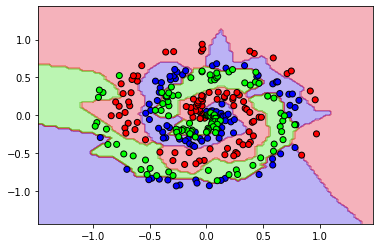

In [132]:
dense1 = LayerDense(2, 64)
activation1 = Relu()
dense2 = LayerDense(64, 3)
activation2 = Softmax_and_LossCrossEntropy()

optimizer = MomemtumOptimizer(lr=1)

epoch = 10000
for _ in range(epoch):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs, y)

    # backward pass
    activation2.backward(y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # updates
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()


def predict(X):
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    return np.argmax(activation2.lossfunc.forward(dense2.outputs), axis=1)


print(confusion_matrix(y, predict(X)))
print(accuracy_score(y_pred=predict(X), y_true=y))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="brg", alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")

plt.show()

# Adagrad Optimzer

[[70 12 18]
 [ 4 89  7]
 [19  5 76]]
0.7833333333333333


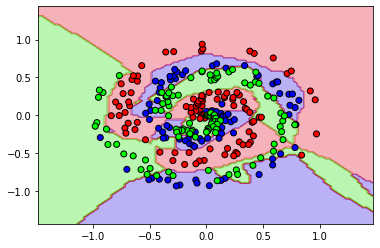

In [133]:
dense1 = LayerDense(2, 64)
activation1 = Relu()
dense2 = LayerDense(64, 3)
activation2 = Softmax_and_LossCrossEntropy()

optimizer = AdagradOptimizer(lr=1)

epoch = 10000
for _ in range(epoch):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs, y)

    # backward pass
    activation2.backward(y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # updates
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()


def predict(X):
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    return np.argmax(activation2.lossfunc.forward(dense2.outputs), axis=1)

print(confusion_matrix(y, predict(X)))
print(accuracy_score(y_pred=predict(X), y_true=y))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="brg", alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")

plt.show()

# RMSPropOptimizer

[[82  4 14]
 [ 0 96  4]
 [13  4 83]]
0.87


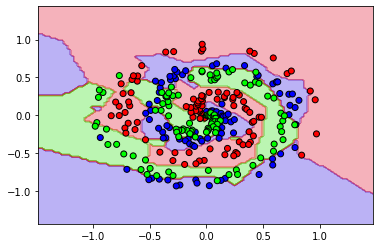

In [134]:
dense1 = LayerDense(2, 64)
activation1 = Relu()
dense2 = LayerDense(64, 3)
activation2 = Softmax_and_LossCrossEntropy()

optimizer = RMSPropOptimizer(lr=0.1, rho=0.99)

epoch = 10000
for _ in range(epoch):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs, y)

    # backward pass
    activation2.backward(y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # updates
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()


def predict(X):
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    return np.argmax(activation2.lossfunc.forward(dense2.outputs), axis=1)


print(confusion_matrix(y, predict(X)))
print(accuracy_score(y_pred=predict(X), y_true=y))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="brg", alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")

plt.show()

# AdamOptimizer

[[96  0  4]
 [ 0 99  1]
 [ 4  0 96]]
0.97


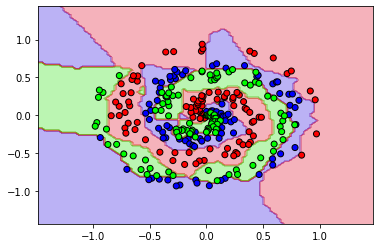

In [139]:
dense1 = LayerDense(2, 64)
activation1 = Relu()
dense2 = LayerDense(64, 3)
activation2 = Softmax_and_LossCrossEntropy()

optimizer = AdamOptimizer(lr=0.02, decay=0.0001)

epoch = 10000
for _ in range(epoch):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs, y)

    # backward pass
    activation2.backward(y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # updates
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()


def predict(X):
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    return np.argmax(activation2.lossfunc.forward(dense2.outputs), axis=1)


print(confusion_matrix(y, predict(X)))
print(accuracy_score(y_pred=predict(X), y_true=y))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="brg", alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")

plt.show()

In [140]:
# np.save("layer1_weights.npy", dense1.weights)
# np.save("layer1_biases.npy", dense1.biases) 

# np.save("layer2_weights.npy", dense2.weights)
# np.save("layer2_biases.npy", dense2.biases)